<span style="font-size: 38px; color: red; font-weight: bold;">Airbnb Price prediction and Insights</span> 

<h1>Overview</h1>

Airbnb provides a platform for property owners to rent out their spaces to travelers. Pricing a
listing effectively is critical for maximizing revenue while staying competitive in the market.
For hosts, understanding what factors influence the price of their listings is essential.
This project aims to build a machine learning model to predict the price of Airbnb listings
based on various features such as property type, room type, location, amenities, and host
characteristics. By analyzing these factors, this project will provide actionable insights to
Airbnb hosts to optimize their listing prices.

<h1>Problem Statement</h1>
The primary objective of this project is to develop a regression model that predicts the price of an Airbnb listing. Using features such as property type, number of reviews, location and amenities, the model will aim to estimate the price accurately. The insight derived from this analysis will help Airbnb hosts understand the key drivers of price, enabling them to make data-driven decisions for pricing their properties. Additionally the project will help Airbnb refine its recommendations for pricing to improve host and guest satisfaction.

<h1>Importing Necessary Libraries</h1>

In [5]:
#importing the necessary libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler 

<h1>Importing Airbnb dataset</h1>

In [7]:
#importing the dataset
df = pd.read_csv("C:/Users/aryan/Desktop/INTERNSHALA/COURSE 6/Course 6 project/PART A/Airbnb_data - airbnb_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

<span style="font-size: 38px; color: blue; font-weight: bold;">DATA CLEANING</span> 

<h1>Identifying columns with null values</h1>

In [10]:
#identifying the columns with null values
df.isnull().sum()

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     968
bedrooms                     91
beds                        131
dtype: int64

<h1>Dropping Irrelevant Columns</h1>

In [12]:
# Create a copy of the original DataFrame
cleaned_df = df.copy()

# Drop irrelevant columns
cleaned_df.drop(columns=[
    'thumbnail_url', 'id', 'description', 'first_review',
    'last_review', 'latitude', 'longitude', 'name', 'zipcode'], inplace=True, errors='ignore')

<h1>Handling missing values</h1>

In [14]:
# Fill missing values
cleaned_df['review_scores_rating'] = cleaned_df['review_scores_rating'].fillna(cleaned_df['review_scores_rating'].median())
cleaned_df['bathrooms'] = cleaned_df['bathrooms'].fillna(cleaned_df['bathrooms'].median())
cleaned_df['host_identity_verified'] = cleaned_df['host_identity_verified'].fillna(cleaned_df['host_identity_verified'].mode()[0])
cleaned_df['host_since'] = cleaned_df['host_since'].fillna('2000-01-01')
cleaned_df['host_has_profile_pic'] = cleaned_df['host_has_profile_pic'].fillna(cleaned_df['host_has_profile_pic'].mode()[0])
cleaned_df['beds'] = cleaned_df['beds'].fillna(cleaned_df['beds'].median())
cleaned_df['bedrooms'] = cleaned_df['bedrooms'].fillna(cleaned_df['bedrooms'].median())


<span style="font-size: 38px; color: blue; font-weight: bold;">FEATURE ENGINEERING</span> 

<h1>Adding new insightful columns </h1>

In [17]:
# FEATURE ENGINEERING

# cleaning the amenities column and adding a new column "num_amenities" displaying the number of amenities per hotel 
cleaned_df['amenities'] = cleaned_df['amenities'].astype(str)
cleaned_df['amenities'] = cleaned_df['amenities'].str.replace(r'[\{\}"\[\]]', '', regex=True)
cleaned_df['amenities'] = cleaned_df['amenities'].str.lower().str.strip()
cleaned_df['num_amenities'] = cleaned_df['amenities'].apply(lambda x: len(x.split(',')) if x else 0)

# creating a new column "host_activity_metrics"

# converting the "host_since" column to "host_years_active" which indicates the total years that the host has been active 
cleaned_df['host_since'] = pd.to_datetime(cleaned_df['host_since'], errors='coerce', dayfirst=True)
cleaned_df['host_years_active'] = (pd.Timestamp('now') - cleaned_df['host_since']).dt.days // 365
cleaned_df['host_years_active'] = cleaned_df['host_years_active'].fillna(0)

# cleaning the "host_response_rate" column 
cleaned_df['host_response_rate'] = cleaned_df['host_response_rate'].astype(str).str.rstrip('%').astype(float)
cleaned_df['host_response_rate'] = cleaned_df['host_response_rate'].fillna(cleaned_df['host_response_rate'].median())

#scale and combine 4 different host components to create "host_activity_metrics" column 
cleaned_df['host_activity_metrics'] = cleaned_df['host_years_active'] * 0.3 + cleaned_df['number_of_reviews'] * 0.25 + cleaned_df['review_scores_rating'] * 0.25 + cleaned_df['host_response_rate'] * 0.2

# creating a new column "neighbourhood_popularity" based on the number of reviews 
neighbourhood_reviews = cleaned_df.groupby('neighbourhood')['number_of_reviews'].sum()
cleaned_df['neighbourhood_popularity'] = cleaned_df['neighbourhood'].map(neighbourhood_reviews)

# removing the unnecessary columns after performing feature engineering 
cleaned_df.drop(columns=['neighbourhood','amenities', 'host_since', 'host_years_active', 'number_of_reviews',
                         'review_scores_rating', 'host_response_rate'], inplace=True, errors='ignore')


<h1>Visualizing the new insightful columns</h1>

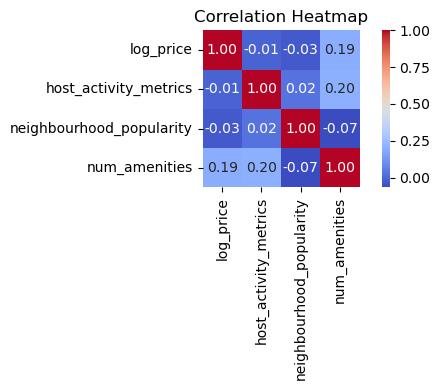

In [19]:
#understanding the correlation of the new columns with price 

# Select relevant columns
correlation_features = ['log_price', 'host_activity_metrics', 'neighbourhood_popularity', 'num_amenities']
corr_matrix = cleaned_df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


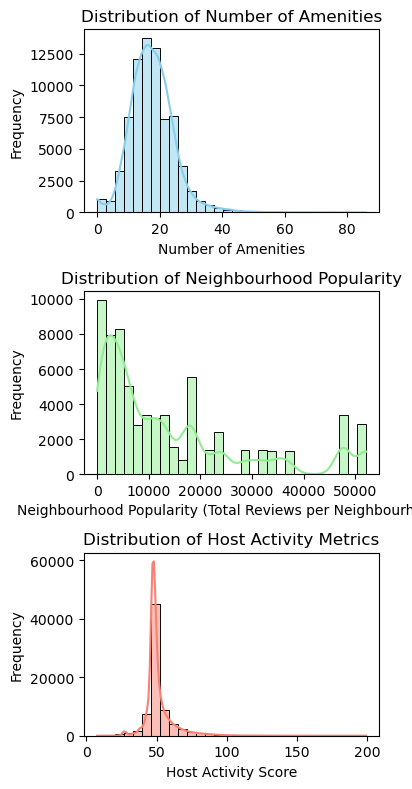

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 8))

# 1. Distribution of Number of Amenities
plt.subplot(3, 1, 1)
sns.histplot(cleaned_df['num_amenities'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Number of Amenities')
plt.xlabel('Number of Amenities')
plt.ylabel('Frequency')

# 2. Distribution of Neighbourhood Popularity
plt.subplot(3, 1, 2)
sns.histplot(cleaned_df['neighbourhood_popularity'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Neighbourhood Popularity')
plt.xlabel('Neighbourhood Popularity (Total Reviews per Neighbourhood)')
plt.ylabel('Frequency')

# 3. Distribution of Host Activity Metrics
plt.subplot(3, 1, 3)
sns.histplot(cleaned_df['host_activity_metrics'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Host Activity Metrics')
plt.xlabel('Host Activity Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


<h1>Insights from Feature Engineering:</h1>


### 1. Number of Amenities (`num_amenities`)
- **Observation:** Listings with a higher number of amenities tend to have slightly higher log-transformed prices.
- **Interpretation:** The relationship is not very strong, suggesting amenities alone do not drive pricing decisions, but they may contribute to the perceived value of a listing.
- **Usage:** This column will be used in the model.

### 2. Host Activity Metrics (`host_activity_metrics`)
- **Observation:** This metric combines various host-related factors like hosting experience and review count.
- **Interpretation:** The correlation with price is weak, indicating that while active and experienced hosts may attract more guests, their impact on pricing is minimal or indirect.
- **Usage:** This feature provides business insights, even if its direct impact on pricing is limited.

### 3. Neighbourhood Popularity (`neighbourhood_popularity`)
- **Observation:** Popularity based on the number of reviews in a neighbourhood does not show a meaningful relationship with price.
- **Interpretation:** A listing being in a high-review area doesn’t necessarily mean it will be priced higher — other factors like room type and quality matter more.
- **Usage:** Although not used directly in the regression model, this feature still provides valuable insights into market dynamics.

> **Note:** These engineered features, while not used directly in the regression model due to low correlation or stakeholder usability, still provide meaningful business insights and enhance the overall understandin
print(markdown_text)
e dataset.
type and





<span style="font-size: 38px; color: blue; font-weight: bold;">EXPLORATORY DATA ANALYSIS</span> 

<h1>Understanding the dataset</h1>

In [24]:
#top 5 rows for reference
cleaned_df.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,bedrooms,beds,num_amenities,host_activity_metrics,neighbourhood_popularity
0,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,t,t,f,1.0,1.0,9,49.40,1469.0
1,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,t,f,t,3.0,3.0,15,46.85,34584.0
2,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,t,t,t,1.0,3.0,19,47.90,28497.0
3,6.620073,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,t,t,f,2.0,2.0,15,46.70,3587.0
4,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,t,t,t,0.0,1.0,12,34.00,5935.0


In [25]:
#information about all the columns in the dataframe
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   log_price                 74111 non-null  float64
 1   property_type             74111 non-null  object 
 2   room_type                 74111 non-null  object 
 3   accommodates              74111 non-null  int64  
 4   bathrooms                 74111 non-null  float64
 5   bed_type                  74111 non-null  object 
 6   cancellation_policy       74111 non-null  object 
 7   cleaning_fee              74111 non-null  bool   
 8   city                      74111 non-null  object 
 9   host_has_profile_pic      74111 non-null  object 
 10  host_identity_verified    74111 non-null  object 
 11  instant_bookable          74111 non-null  object 
 12  bedrooms                  74111 non-null  float64
 13  beds                      74111 non-null  float64
 14  num_am

In [26]:
#summary statistics of the dataframe
print(cleaned_df.describe())


          log_price  accommodates     bathrooms      bedrooms          beds  \
count  74111.000000  74111.000000  74111.000000  74111.000000  74111.000000   
mean       4.782069      3.155146      1.234628      1.265467      1.709611   
std        0.717394      2.153589      0.581386      0.851671      1.253389   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        4.317488      2.000000      1.000000      1.000000      1.000000   
50%        4.709530      2.000000      1.000000      1.000000      1.000000   
75%        5.220356      4.000000      1.000000      1.000000      2.000000   
max        7.600402     16.000000      8.000000     10.000000     18.000000   

       num_amenities  host_activity_metrics  neighbourhood_popularity  
count   74111.000000           74111.000000              67239.000000  
mean       17.594500              51.055135              14010.203290  
std         6.956409              10.336665              14658.120536  


<h1>Target Variable Analysis</h1>

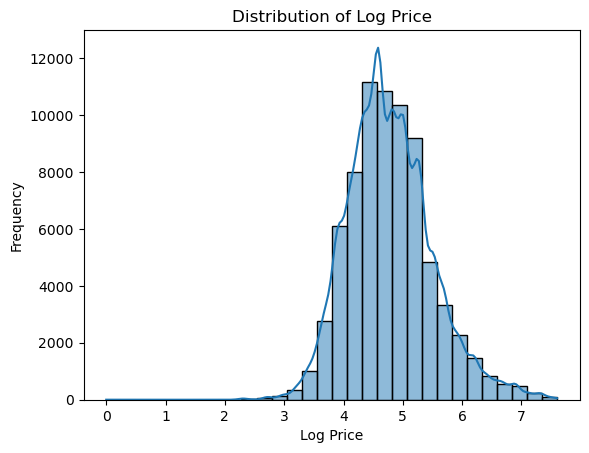

In [28]:
# Visualizing the distribution of the target variable (log_price)
sns.histplot(cleaned_df['log_price'], kde=True, bins=30)
plt.title('Distribution of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

<h1>Numerical Predictor Analysis</h1>

In [30]:
#numerical predictor variables in the dataframe
num_predictors = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'num_amenities', 'host_activity_metrics', 'neighbourhood_popularity']

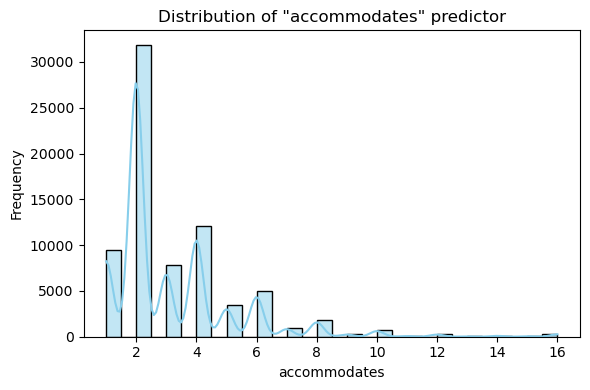

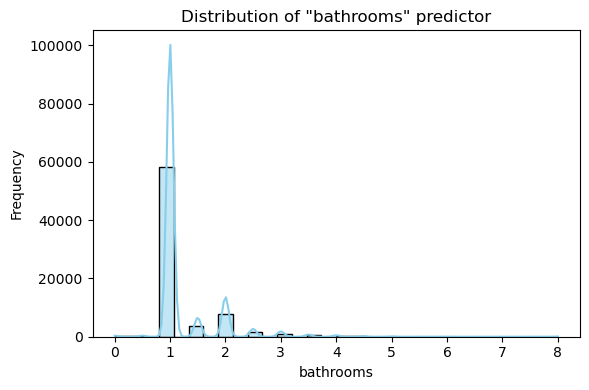

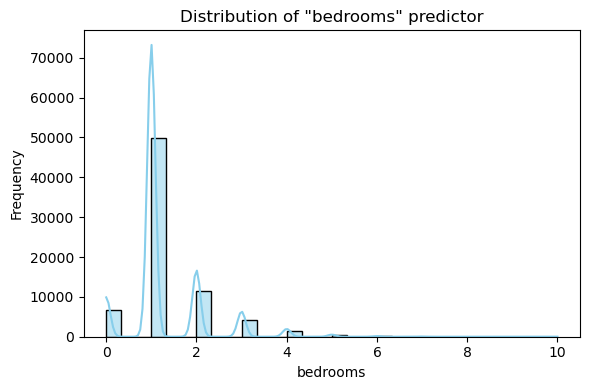

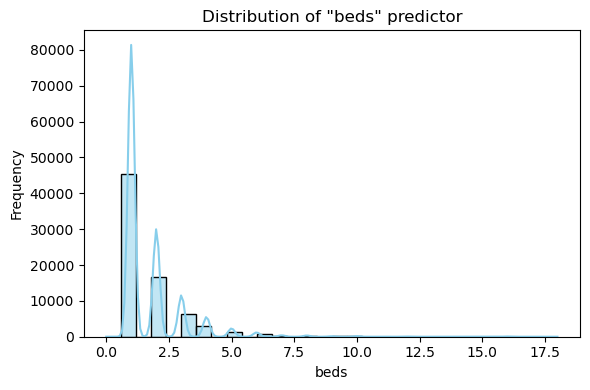

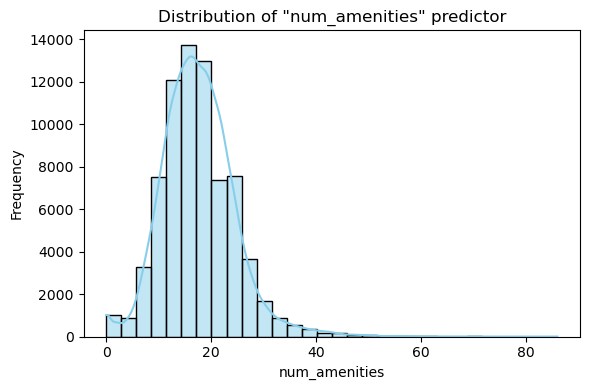

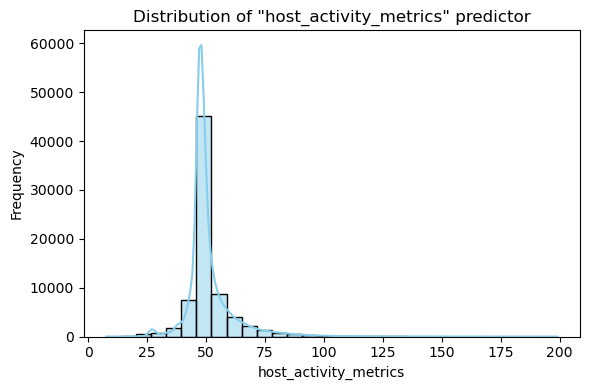

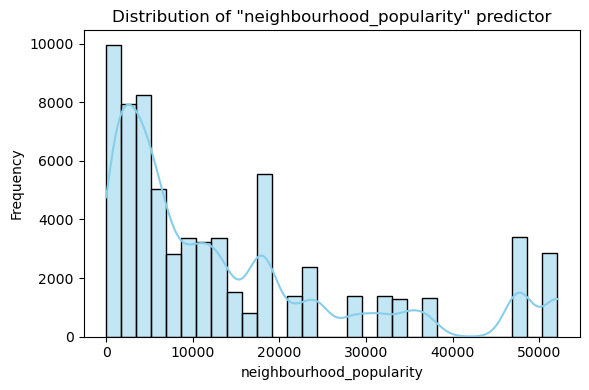

In [31]:
# Distribution of numerical predictor variables
import seaborn as sns
import matplotlib.pyplot as plt

for col in num_predictors:
    plt.figure(figsize=(6, 4))
    sns.histplot(cleaned_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of \"{col}\" predictor')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


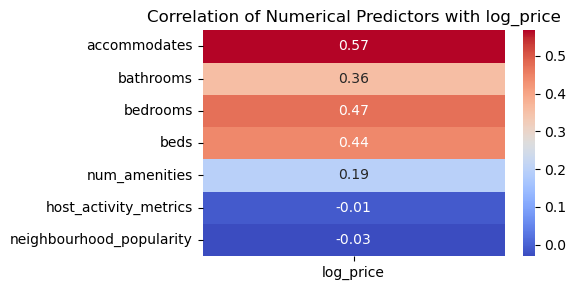

In [32]:
# Calculate correlation of each numerical predictor with log_price
correlations = cleaned_df[num_predictors + ['log_price']].corr()['log_price'].drop('log_price')

# Plot the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Numerical Predictors with log_price")
plt.tight_layout()
plt.show()


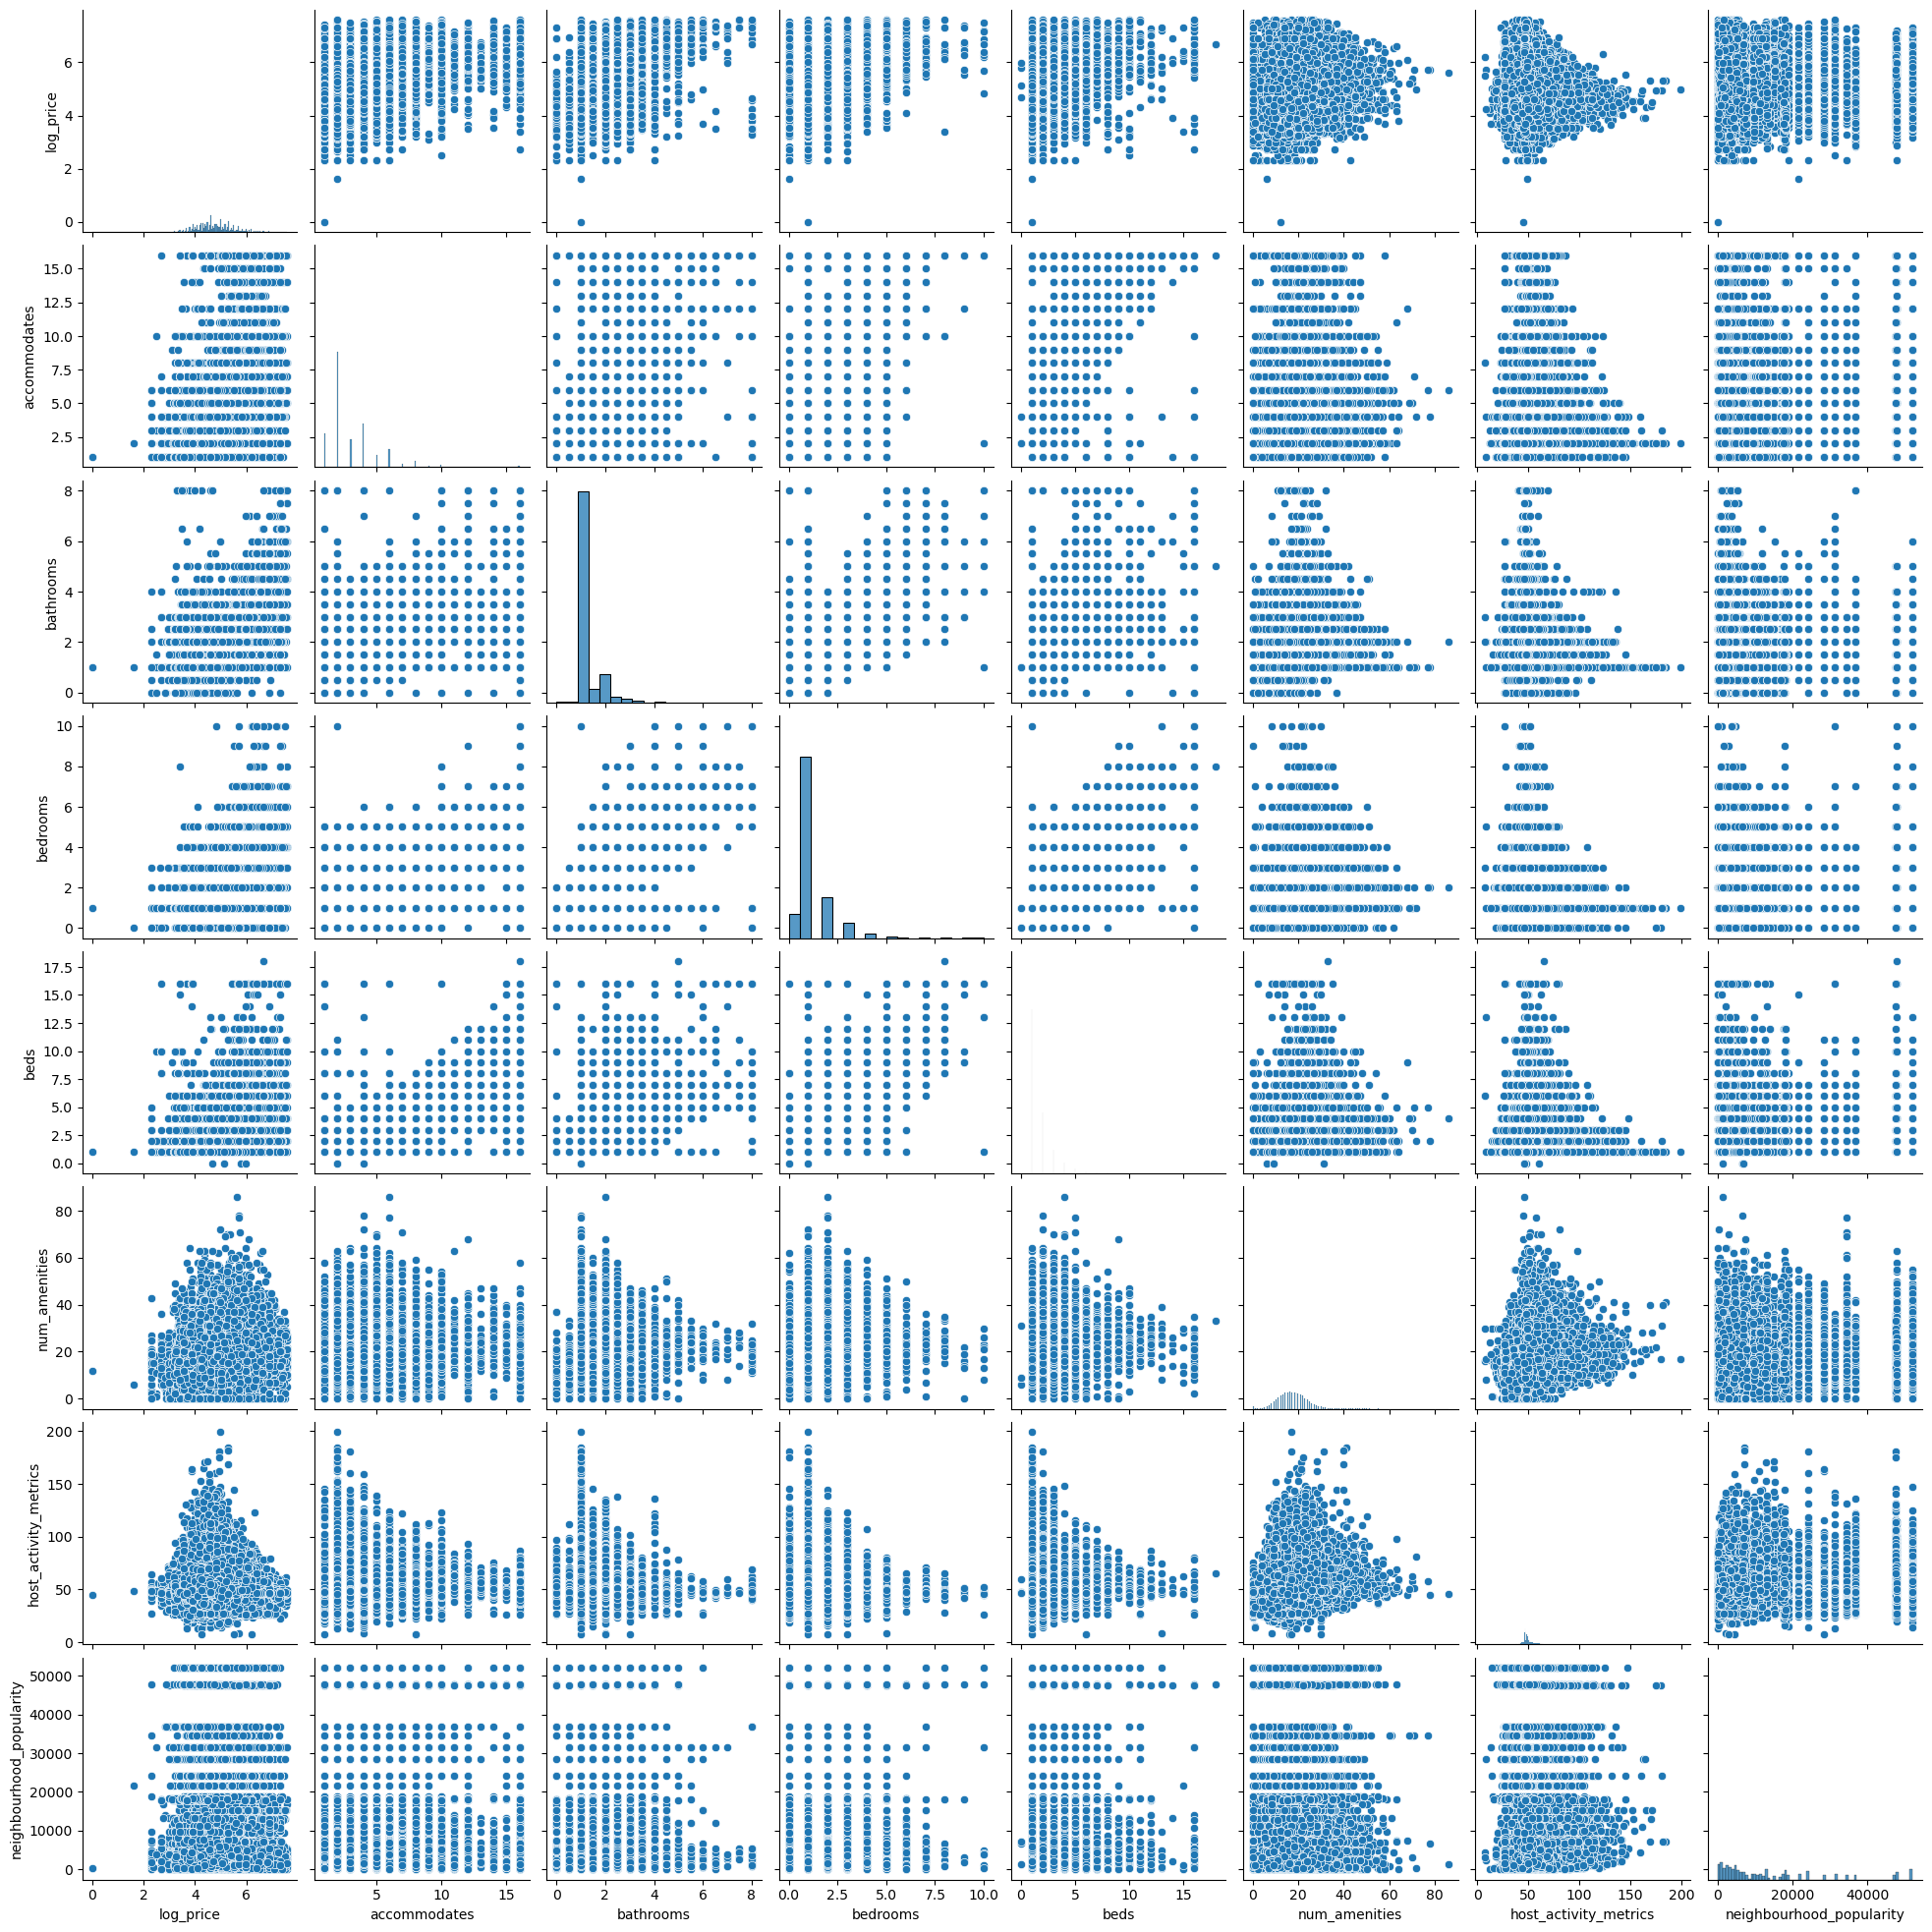

In [33]:
#matrix of scatterplots visualising all relationship between the predictor variables and the target variables
sns.pairplot(cleaned_df[['log_price'] + num_predictors])

<h1>Categorical Predictor Analysis</h1>

In [35]:
#categorical predictor in the dataframe
cat_predictors = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 
                  'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

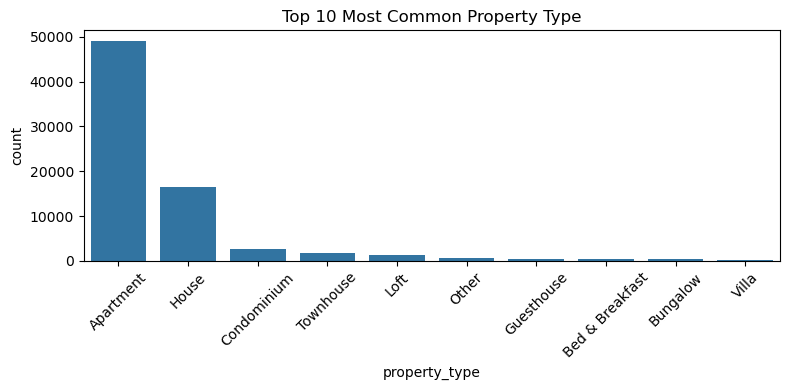

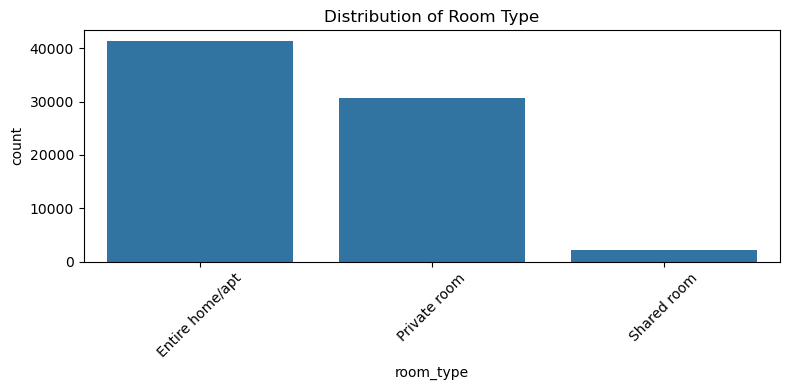

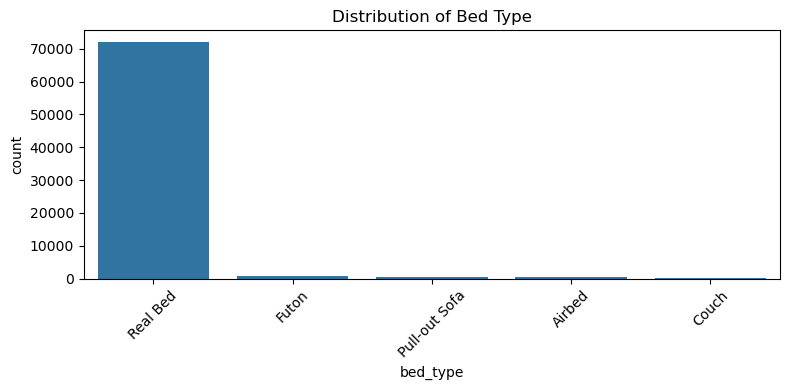

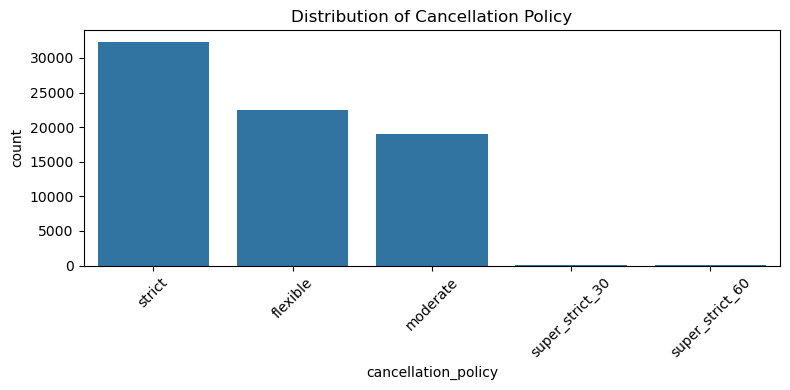

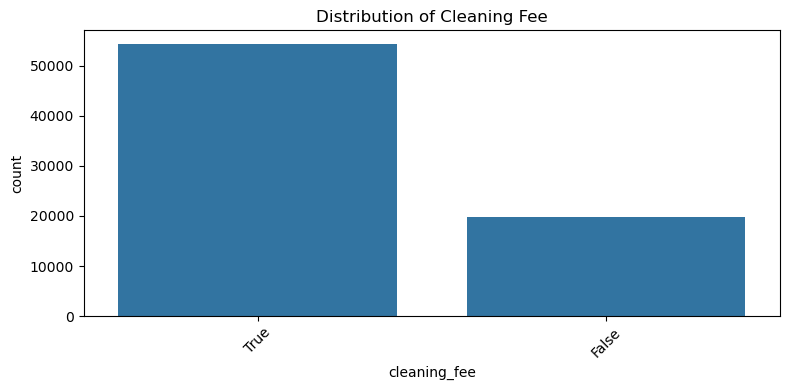

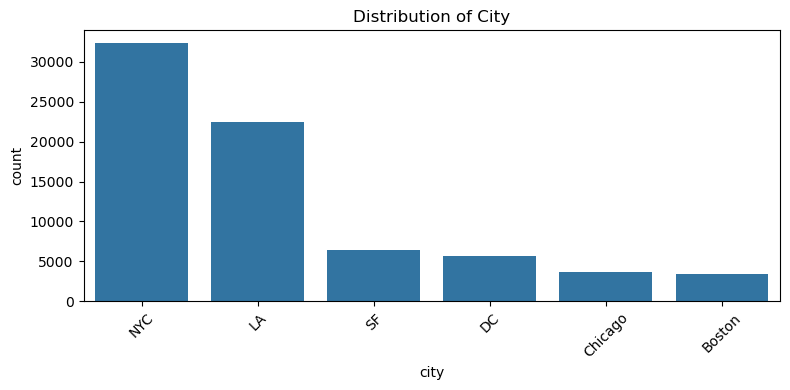

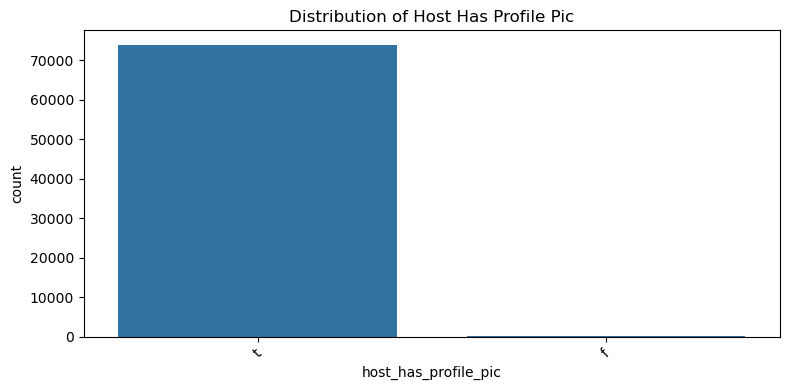

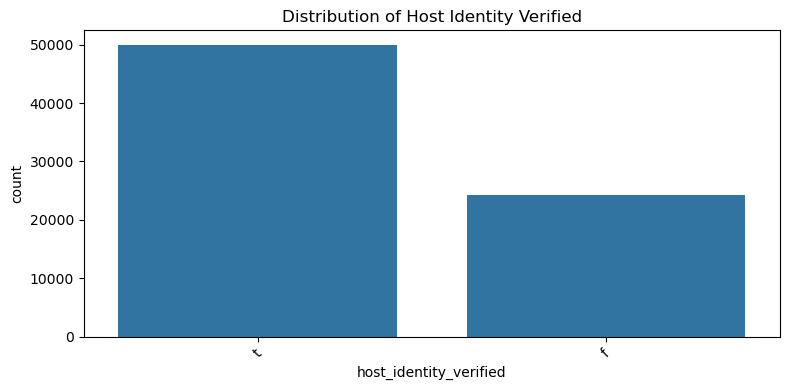

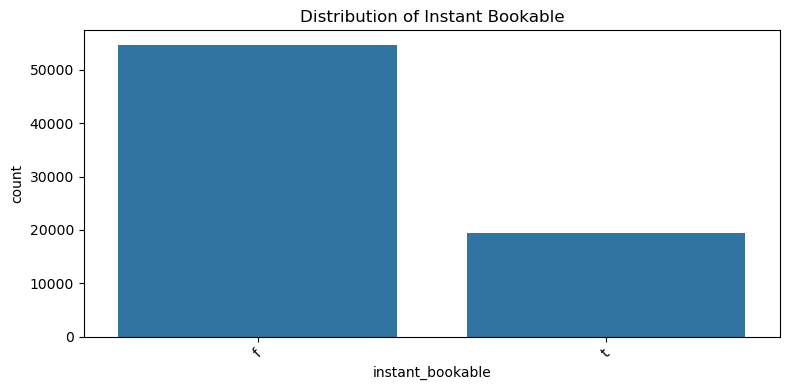

In [36]:
#plotting count plots to show the distribution of each of the categorical predictors 
for col in cat_predictors:
    plt.figure(figsize=(8, 4))

    #if statement because the property_type column contains 35 unique values, therefore im displaying only the top 10 values
    if col == 'property_type':
        top_categories = cleaned_df[col].value_counts().nlargest(10).index
        sns.countplot(data=cleaned_df[cleaned_df[col].isin(top_categories)],
                      x=col,
                      order=top_categories)
        plt.title(f"Top 10 Most Common {col.replace('_', ' ').title()}")
    else:
        sns.countplot(data=cleaned_df, x=col, order=cleaned_df[col].value_counts().index)
        plt.title(f"Distribution of {col.replace('_', ' ').title()}")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



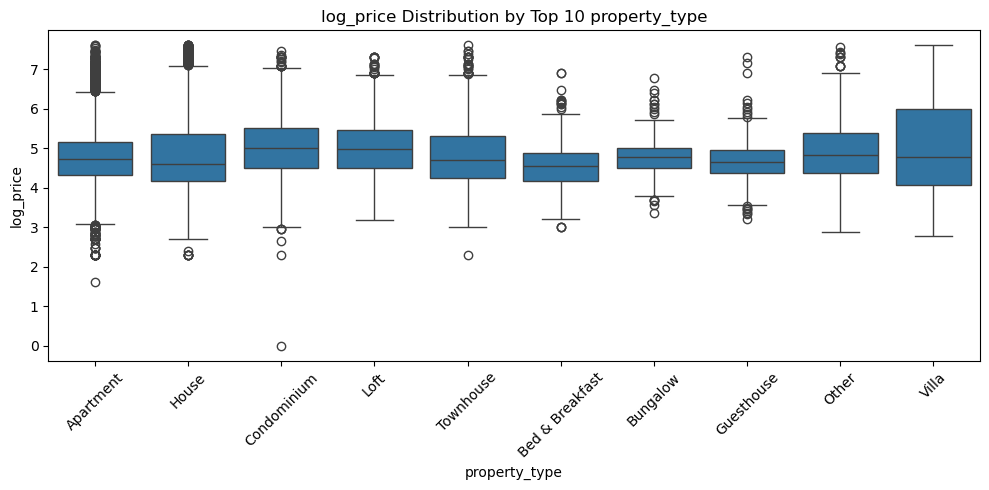

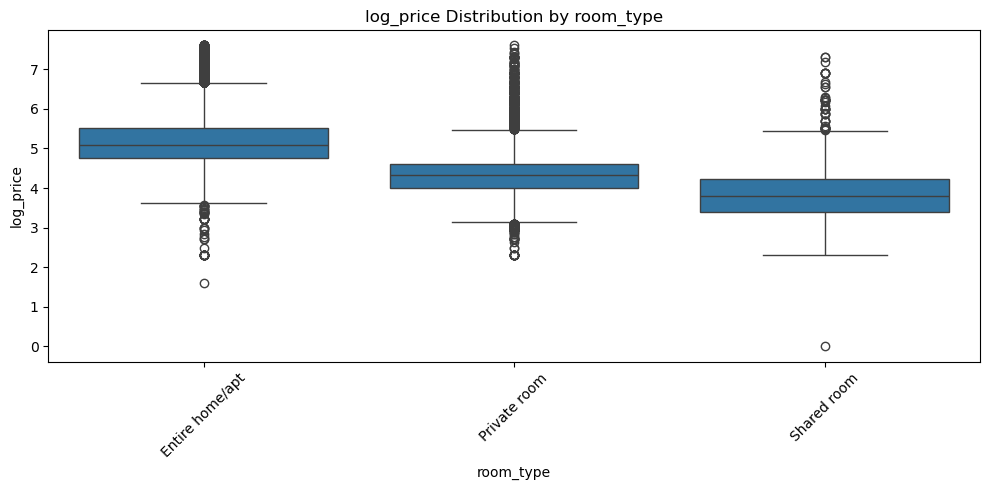

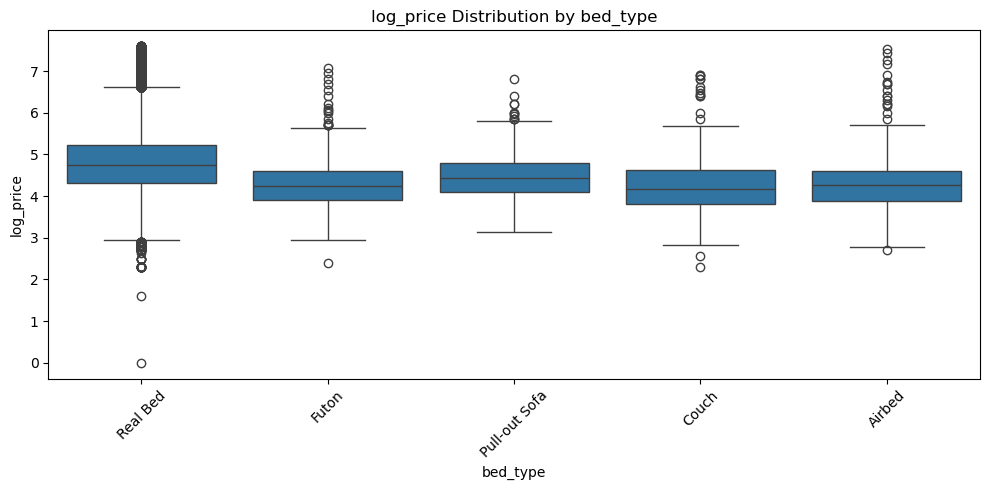

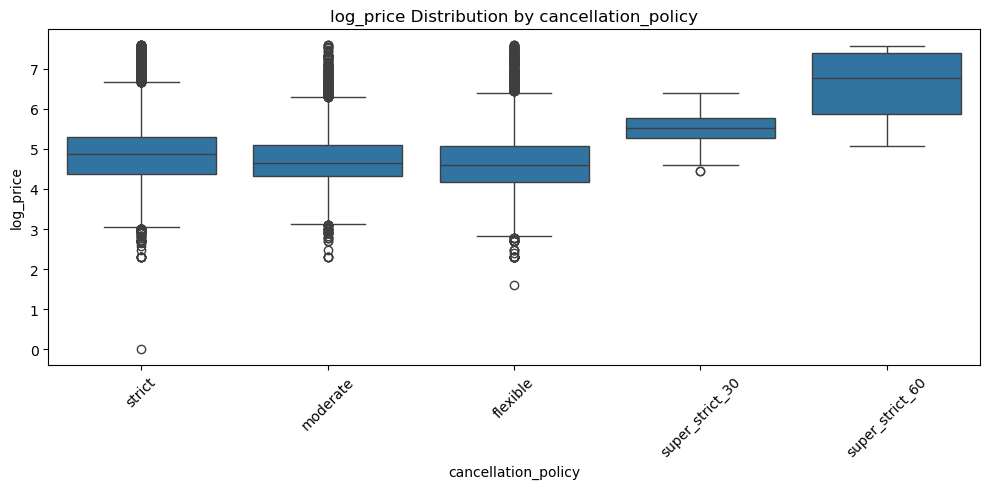

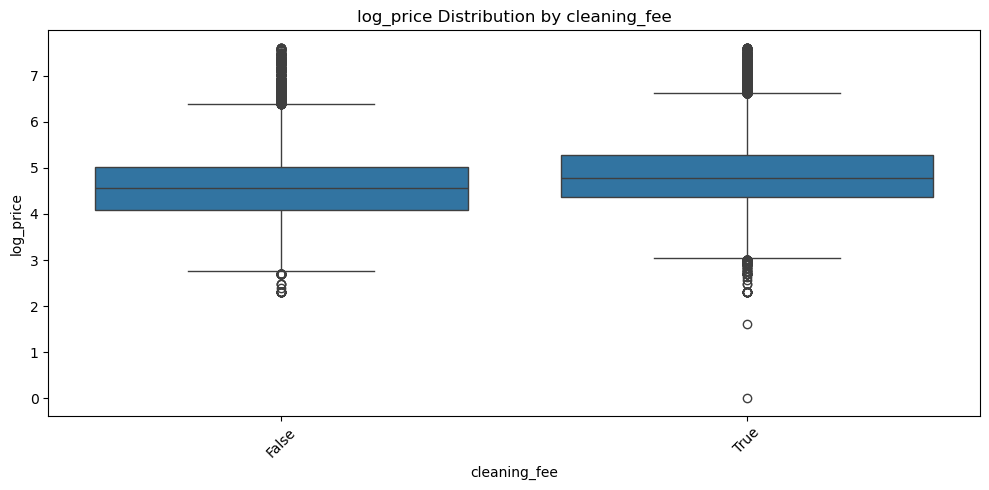

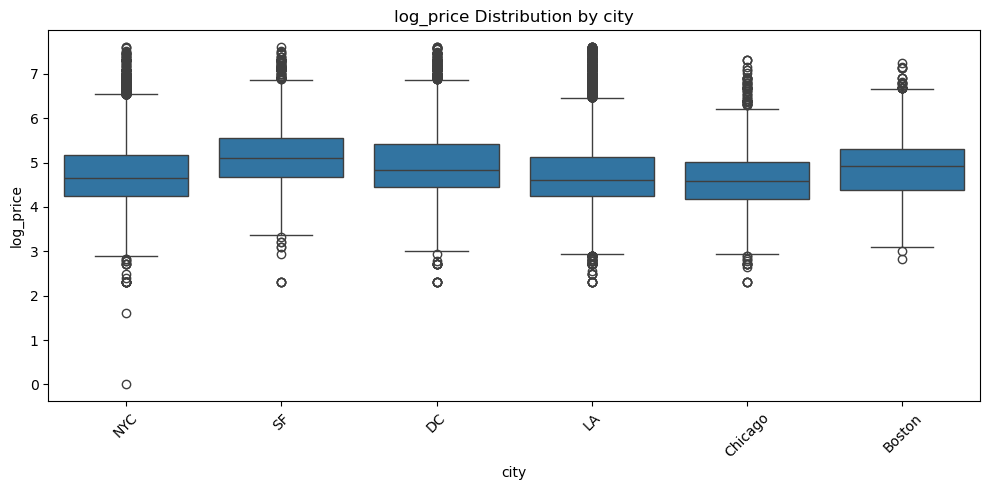

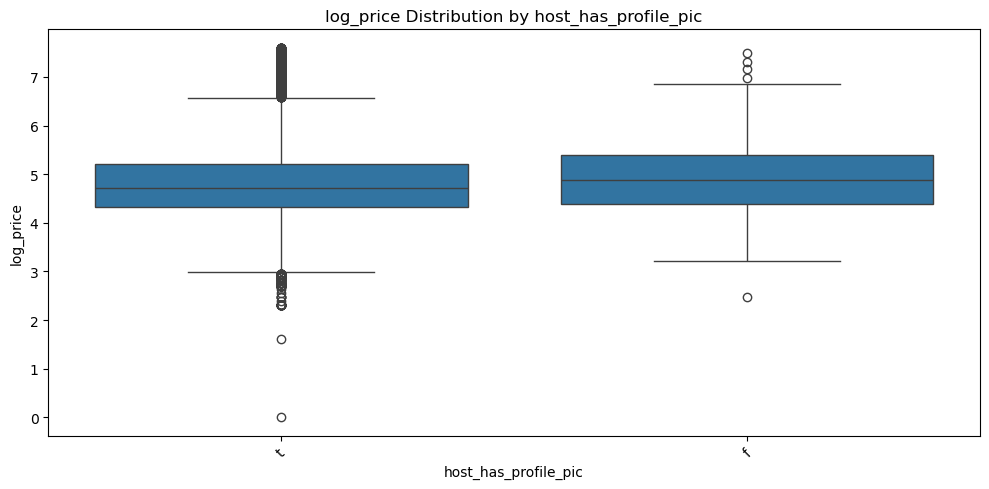

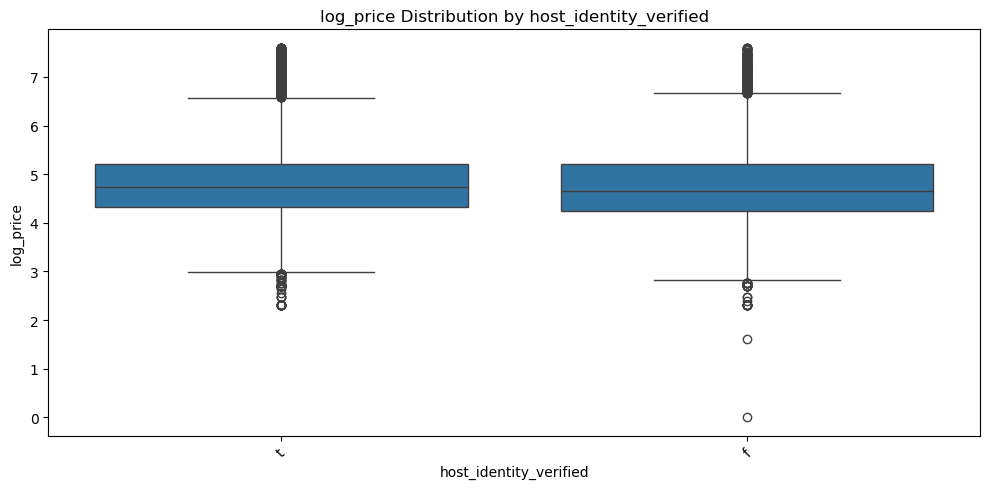

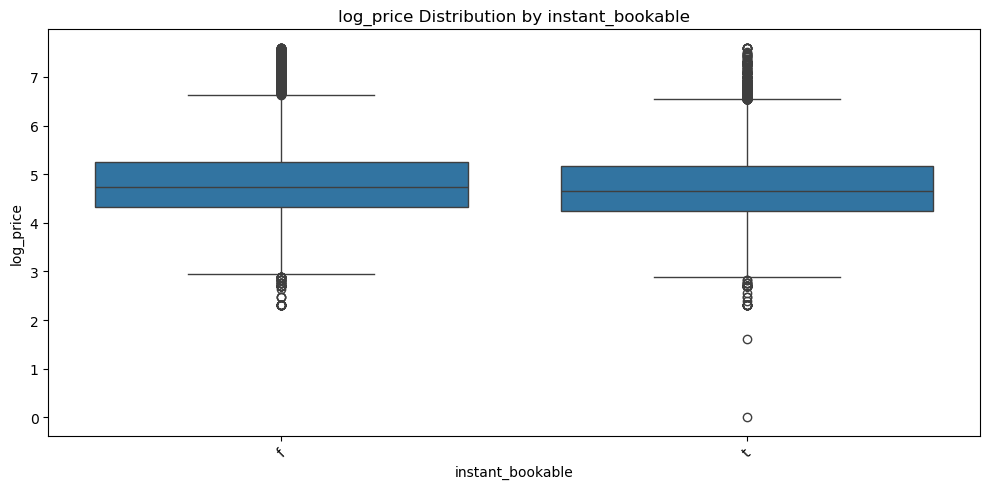

In [37]:
#boxplots to show how each of the categorical variables are related to the target variable - log_price
for col in cat_predictors:
    plt.figure(figsize=(10, 5))
    
    if col == 'property_type':
        # Get top 10 most frequent property types
        top_10_types = cleaned_df[col].value_counts().nlargest(10).index
        subset = cleaned_df[cleaned_df[col].isin(top_10_types)]
        sns.boxplot(data=subset, x=col, y='log_price')
        plt.title(f"log_price Distribution by Top 10 {col}")
    else:
        sns.boxplot(data=cleaned_df, x=col, y='log_price')
        plt.title(f"log_price Distribution by {col}")
        
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



###  EDA Insights

#### 1. Dataset Composition
- The dataset consists of **17 columns**, which includes:
  - **8 numerical columns**
  - **9 categorical columns**

#### 2. Numerical Predictor Analysis
- **Descriptive Summary**:
  - Numerical variables like `accommodates`, `bathrooms`, `bedrooms`, and `beds` vary across listings, capturing differences in listing sizes.
  - `num_amenities` shows a wide spread, while `host_activity_metrics` and `neighbourhood_popularity` have high variability but weak relevance to price.

- **Correlation with Target (`log_price`)**:
  - The following variables show **strong positive correlation** with `log_price`, and are thus **important for price prediction**:
    - `accommodates` (**0.57**)
    - `bedrooms` (**0.47**)
    - `beds` (**0.44**)
    - `bathrooms` (**0.35**)
  - `num_amenities` shows a **moderate positive correlation** (**0.19**) and is included for its potential impact.
  - `host_activity_metrics` and `neighbourhood_popularity` show **negligible or negative correlation** and were **excluded from the model**.

#### 3. Categorical Predictor Analysis
- The dataset includes diverse categorical features:
  - High-cardinality: `property_type` (**35 categories**) — only the **top 10** most frequent values were visualized for clarity.
  - Others include:  
    - `room_type` (3), `bed_type` (5), `cancellation_policy` (5), `cleaning_fee` (2), `city` (6), and binary fields like `host_has_profile_pic`, `host_identity_verified`, and `instant_bookable`.
- **All categorical predictors** were retained for modeling as they may hold valuable signals influencing listing prices.


<span style="font-size: 38px; color: blue; font-weight: bold;">DATA TRANSFORMATION</span> 

In [40]:
#dataframe information 
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   log_price                 74111 non-null  float64
 1   property_type             74111 non-null  object 
 2   room_type                 74111 non-null  object 
 3   accommodates              74111 non-null  int64  
 4   bathrooms                 74111 non-null  float64
 5   bed_type                  74111 non-null  object 
 6   cancellation_policy       74111 non-null  object 
 7   cleaning_fee              74111 non-null  bool   
 8   city                      74111 non-null  object 
 9   host_has_profile_pic      74111 non-null  object 
 10  host_identity_verified    74111 non-null  object 
 11  instant_bookable          74111 non-null  object 
 12  bedrooms                  74111 non-null  float64
 13  beds                      74111 non-null  float64
 14  num_am

In [41]:
#identifying the numerical columns and categorical columns that will be used in the model later on
numerical_columns_names = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
categorical_columns_names = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 
                       'city', 'host_has_profile_pic','host_identity_verified', 'instant_bookable']

<h1>Encoding Categorical columns</h1>

In [43]:
# the categorical columns in the data will be encoded using OneHotEncoder 
# im using OneHotEncoder to encode these columns, because the cardinality of the columns is too high for LabelEncoder


# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform categorical columns from cleaned_df
encoded_array = encoder.fit_transform(cleaned_df[categorical_columns_names])

# Get the encoded column names in order
encoded_col_names = encoder.get_feature_names_out(categorical_columns_names)

# Create DataFrame from encoded array
encoded_columns_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=cleaned_df.index)


<span style="font-size: 38px; color: blue; font-weight: bold;">MODEL DEVELOPMENT AND EVALUATION</span> 

<h1>Defining Predictors and Target Variable</h1>

In [46]:
#defining the predictors by concatenating the numerical columns and the encoded data 
X = pd.concat([cleaned_df[numerical_columns_names], encoded_columns_df], axis=1)

#defining the target variable which is log_price 
y = cleaned_df['log_price']


<h1>Splitting the data into Training and Testing sets</h1>

In [48]:
#performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h1>Scaling the numerical columns for efficiency</h1>

In [50]:
#initialize the standard scaler class 
scaler = StandardScaler()

# Fit and transform the numerical columns of the training set
X_train[numerical_columns_names] = scaler.fit_transform(X_train[numerical_columns_names])

# Transform the numerical part of test set
X_test[numerical_columns_names] = scaler.transform(X_test[numerical_columns_names])


<h1>Training, Optimizing and Evaluating the Regression model</h1>

In [52]:
# Initialize GridSearchCV with the parameter grid
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

#the range of alpha values that needs to be tested
alpha_values = [0.1, 10, 100, 1000]

#passing the alpha values in the parameter grid
param_grid = {'alpha': alpha_values}

#initializing the ridge regression model
ridge_model = Ridge()

# set up GridSearchCV to find the best alpha value for the ridge regression model using 5-fold cross-validation
# we use 'r2' as the scoring metric to evaluate model performance
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Step 4: Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2 Score:", r2)

# (Optional) Print the best hyperparameters
print("Best Alpha:", grid_search.best_params_['alpha'])



MSE: 0.22743072510057558
R2 Score: 0.5572916885560248
Best Alpha: 10


<h1>Cross validation to check for overfitting</h1>

In [54]:
from sklearn.model_selection import cross_val_score

# perform cross-validation for the best ridge model selected from grid_search
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("Cross-validated R2 Scores:", cv_scores)


Cross-validated R2 Scores: [0.55718526 0.56326317 0.5611238  0.54556542 0.54787059]


### Modeling Insights

1. **Why Ridge Regression was chosen over Linear Regression**  
   - I initially experimented with a standard **Linear Regression** model. However, it produced **non-optimal results** and underperformed on the test set, suggesting it wasn’t capturing the complexity of the data effectively.  
   - To address this, I shifted to **Ridge Regression**, which incorporates **L2 regularization**. This helps by **penalizing large coefficients**, reducing model variance, and controlling overfitting.  
   - Ridge Regression turned out to be more reliable for this use case, offering better **generalization** without significantly compromising accuracy.

2. **Grid Search Results (Hyperparameter Tuning)**  
   - I applied **GridSearchCV** to tune the regularization strength (`alpha`) across values: `[10, 100, 200, 500, 1000, 10000]`.  
   - The best-performing model was found with:  
     - **Best Alpha:** `10`  
     - **Mean Squared Error (MSE):** `0.2274`  
     - **R² Score:** `0.5573`  
   - These metrics indicate that the model is able to explain about **55.7% of the variance** in the log-transformed Airbnb prices — a solid outcome for real-world pricing data.

3. **Cross-Validated R² Scores**  
   - I conducted **5-Fold Cross-Validation** to ensure the model performs consistently across different data splits. The scores were:  
     `[0.5572, 0.5633, 0.5611, 0.5456, 0.5479]`  
   - This shows the model has **low variance**, suggesting it is **stable** and **generalizes well** to unseen data.

4. **Overall General Insights**  
   - The final model captures a **substantial portion of pricing variability**, despite the complexity and unpredictability of Airbnb listings.  
   - External factors like seasonality, guest reviews, demand surges, and listing presentation (images, descriptions) can significantly affect prices — and are not included in this dataset.  
   - Key modeling steps like **feature scaling**, **encoding**, and **hyperparameter tuning** played a crucial role in improving performance.  
   - **Ridge Regression**, with its ability to manage multicollinearity and overfitting, proved to be the most effective among all the models tested.  
   - The use of **GridSearchCV** ensured the model was well-tuned, offering a balanced and dependable points or a video script next!
e chosen model architecture.ed on the selected features.


<span style="font-size: 38px; color: blue; font-weight: bold;">BUILDING A PREDICTION CLASS</span> 

<h1>AirbnbPricePredictor Class Definition</h1>

In [58]:
#defining the input columns as used while training the model 
input_columns = X_train.columns.tolist()

class AirbnbPricePredictor:
    #constructor to initialize the encoder, scaler, ridge model and the input columns
    def __init__(self, encoder, scaler, model, input_columns):
        self.encoder = encoder
        self.scaler = scaler
        self.model = model
        self.input_columns = input_columns

    #function to take the user input
    def take_input(self):
        print("Please provide the following details to predict the Airbnb listing price:\n")

        accommodates = int(input("Number of accommodates: "))
        bathrooms = float(input("Number of bathrooms: "))
        bedrooms = int(input("Number of bedrooms: "))
        beds = int(input("Number of beds: "))

        print("\nSelect property type from the following list:")
        property_types = ['Apartment', 'House', 'Condominium', 'Loft', 'Townhouse', 'Hostel', 'Guest suite',
                          'Bed & Breakfast', 'Bungalow', 'Guesthouse', 'Dorm', 'Other', 'Camper/RV', 'Villa',
                          'Boutique hotel', 'Timeshare', 'In-law', 'Boat', 'Serviced apartment', 'Castle',
                          'Cabin', 'Treehouse', 'Tipi', 'Vacation home', 'Tent', 'Hut', 'Casa particular',
                          'Chalet', 'Yurt', 'Earth House', 'Parking Space', 'Train', 'Cave', 'Lighthouse', 'Island']
        print(property_types)
        property_type = input("Enter property type exactly as shown above: ")

        print("\nSelect room type from:", ['Entire home/apt', 'Private room', 'Shared room'])
        room_type = input("Enter room type: ")

        print("\nSelect bed type from:", ['Real Bed', 'Futon', 'Pull-out Sofa', 'Couch', 'Airbed'])
        bed_type = input("Enter bed type: ")

        print("\nSelect cancellation policy:")
        print("1 - strict\n2 - moderate\n3 - flexible\n4 - super_strict_30\n5 - super_strict_60")
        cancellation_options = ['strict', 'moderate', 'flexible', 'super_strict_30', 'super_strict_60']
        cancellation_policy = cancellation_options[int(input("Enter the number (1-5): ")) - 1]

        cleaning_fee_input = input("\nIs there a cleaning fee? (yes/no): ").strip().lower()
        cleaning_fee = True if cleaning_fee_input == 'yes' else False

        city = input("\nEnter the city (NYC, SF, DC, LA, Chicago, Boston): ").strip().upper()

        host_has_profile_pic = input("\nDoes the host have a profile picture? (yes/no): ").strip().lower()
        host_has_profile_pic = 't' if host_has_profile_pic == 'yes' else 'f'

        host_identity_verified = input("\nIs the host identity verified? (yes/no): ").strip().lower()
        host_identity_verified = 't' if host_identity_verified == 'yes' else 'f'

        instant_bookable = input("\nIs the listing instantly bookable? (yes/no): ").strip().lower()
        instant_bookable = 't' if instant_bookable == 'yes' else 'f'

        #converting the input data into a dataframe for the model 
        input_data = pd.DataFrame([{
            'accommodates': accommodates,
            'bathrooms': bathrooms,
            'bedrooms': bedrooms,
            'beds': beds,
            'property_type': property_type,
            'room_type': room_type,
            'bed_type': bed_type,
            'cancellation_policy': cancellation_policy,
            'cleaning_fee': cleaning_fee,
            'city': city,
            'host_has_profile_pic': host_has_profile_pic,
            'host_identity_verified': host_identity_verified,
            'instant_bookable': instant_bookable
        }])

        return input_data

    #function to scale and encode the user input to match the training data 
    def preprocess_input(self, input_data):
        numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
        categorical_features = [col for col in input_data.columns if col not in numerical_features]
    
        #encoding the categorical input data
        encoded_cats = self.encoder.transform(input_data[categorical_features])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out(categorical_features))
    
        #scaling the numerical input data 
        scaled_nums = self.scaler.transform(input_data[numerical_features])
        scaled_df = pd.DataFrame(scaled_nums, columns=numerical_features)
    
        #combining the scaled data and the encoded data 
        processed_input = pd.concat([scaled_df, encoded_df], axis=1)
    
        # this ensures the column order matches training data order
        processed_input = processed_input.reindex(columns=self.input_columns, fill_value=0)
    
        return processed_input


    #function to use the model to predict the target 
    def predict(self, input_data):
        processed_input = self.preprocess_input(input_data)
        prediction = self.model.predict(processed_input)
        return prediction[0]


<h1>Instantiate Predictor & Make a Prediction</h1>

In [60]:
# Instantiate the predictor class
predictor = AirbnbPricePredictor(
    encoder=encoder,
    scaler=scaler,
    model=best_model,
    input_columns=input_columns
)

# Take user input manually
user_input_df = predictor.take_input()

# Predict the log price
log_price_prediction = predictor.predict(user_input_df)

# Convert log price back to actual price using exponential
price_prediction = np.exp(log_price_prediction)

# Show the result
print(f"\nPredicted Airbnb Price: ${price_prediction:.2f}")


Please provide the following details to predict the Airbnb listing price:



Number of accommodates:  3
Number of bathrooms:  2
Number of bedrooms:  3
Number of beds:  3



Select property type from the following list:
['Apartment', 'House', 'Condominium', 'Loft', 'Townhouse', 'Hostel', 'Guest suite', 'Bed & Breakfast', 'Bungalow', 'Guesthouse', 'Dorm', 'Other', 'Camper/RV', 'Villa', 'Boutique hotel', 'Timeshare', 'In-law', 'Boat', 'Serviced apartment', 'Castle', 'Cabin', 'Treehouse', 'Tipi', 'Vacation home', 'Tent', 'Hut', 'Casa particular', 'Chalet', 'Yurt', 'Earth House', 'Parking Space', 'Train', 'Cave', 'Lighthouse', 'Island']


Enter property type exactly as shown above:  Villa



Select room type from: ['Entire home/apt', 'Private room', 'Shared room']


Enter room type:  Private room



Select bed type from: ['Real Bed', 'Futon', 'Pull-out Sofa', 'Couch', 'Airbed']


Enter bed type:  Real Bed



Select cancellation policy:
1 - strict
2 - moderate
3 - flexible
4 - super_strict_30
5 - super_strict_60


Enter the number (1-5):  3

Is there a cleaning fee? (yes/no):  yes

Enter the city (NYC, SF, DC, LA, Chicago, Boston):  DC

Does the host have a profile picture? (yes/no):  yes

Is the host identity verified? (yes/no):  yes

Is the listing instantly bookable? (yes/no):  yes



Predicted Airbnb Price: $131.77


<h1>Prediction Class Overview</h1>

1. **Purpose**  
   - Encapsulate the end-to-end prediction pipeline in a single, reusable class.  
   - Ensure consistency between training and inference by reusing the same encoder, scaler, and feature ordering.

2. **Class Structure**  
   - **`__init__(encoder, scaler, model, input_columns)`**  
     - Stores the fitted `OneHotEncoder`, `StandardScaler`, trained Ridge model, and the exact list of feature names.  
   - **`take_input()`**  
     - Prompts for numeric inputs (`accommodates`, `bathrooms`, `bedrooms`, `beds`).  
     - Presents valid options for categorical inputs (e.g., property type list, room type list, yes/no for booleans).  
     - Normalizes responses (case-insensitive, converts yes/no to `t`/`f`).  
   - **`preprocess_input(input_data)`**  
     - Applies the saved scaler to numeric features.  
     - Uses the saved encoder to one-hot encode categorical features.  
     - Concatenates and reindexes columns to match the training DataFrame exactly.  
   - **`predict(input_data)`**  
     - Calls `preprocess_input()`, feeds the result to the Ridge model, and returns the log-price prediction.

3. **Inference Workflow**  
   1. **Instantiate** the class with `(encoder, scaler, best_model, input_columns)`.  
   2. **Call** `take_input()` to collect user values interactively.  
   3. **Call** `predict(user_input_df)` to get the predicted log-price.  
   4. **Convert** to actual price via `np.exp(log_price)`.  
   5. **Output** the final price estimate.

This design guarantees that user inputs undergo the same preprocessing steps as the training data, producing reliable and reproducible price predictions.  
